In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from sklearn.preprocessing import quantile_transform

%matplotlib inline

In [2]:
plt.style.use('seaborn')

In [3]:
full = pd.read_csv('data/CA1_6_1_clean.csv')

In [4]:
full.head()

,time,0N,1N,2N,3N,4N,5N,6N,7N,8N,...,583N,584N,585N,586N,587N,588N,589N,x,y,segment
0,6,-0.004105,-0.002713,0.002400,-0.002804,0.013982,0.004319,-0.003357,-0.001776,-0.002052,...,0.000585,0.005413,0.009618,0.004061,0.004675,0.001152,-0.000333,-15.463624,2.932973,4.0
1,7,-0.004401,-0.004511,0.001104,-0.002070,0.012163,0.003325,-0.001147,-0.003996,-0.003540,...,-0.000170,0.007227,0.008670,0.006076,0.006172,-0.001081,-0.002290,-16.404171,3.408579,4.0
2,8,-0.003786,-0.005022,0.001733,-0.000330,0.013810,0.003872,-0.003216,-0.002088,-0.003463,...,-0.001343,0.007866,0.008944,0.009129,0.003572,0.000140,-0.003384,-17.335852,3.910841,4.0
3,9,-0.005539,-0.005892,-0.000947,-0.003324,0.012719,0.001616,-0.002414,-0.003358,-0.002223,...,0.000458,0.006610,0.009690,0.007303,0.006286,-0.001653,-0.002121,-18.261171,4.434826,4.0
4,10,-0.004962,-0.007518,0.002856,-0.002459,0.012671,0.004508,-0.002190,-0.003734,-0.000925,...,-0.000420,0.006400,0.007676,0.003326,0.006363,-0.001662,-0.003236,-19.161957,5.008783,4.0


Idea:
* Take n(say, 20) best neurons that have highest MI with some variable (probably angle or a segment)
* Look at their time series in dynamics

In [5]:
def get_angle(coordinates, cx = 0, cy = 0):
    return np.angle((coordinates['x'] - cx) + 1j * (coordinates['y'] - cy))

In [6]:
x_max, y_max = full[['x', 'y']].max()
x_min, y_min = full[['x', 'y']].min()

radius_x = (x_max - x_min) / 2
radius_y = (y_max - y_min) / 2
radius = (radius_x+radius_y)/2

cx1 = x_max - radius
cx2 = x_min + radius
cx = (cx1 + cx2) / 2
cy1 = y_max - radius
cy2 = y_min + radius
cy = (cy1 + cy2) / 2

In [7]:
get_angle({'x': -1, 'y':-1})
# it works

-2.356194490192345

The only problem is the 180 deg angle => See how the model performs

In [8]:
mi = full.copy()

In [9]:
mi['ang'] = get_angle(mi, cx, cy)

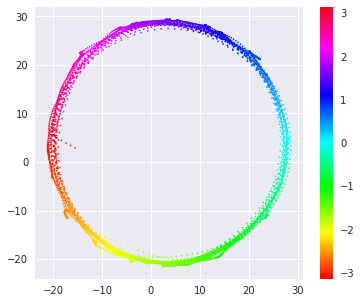

In [10]:
fig, ax = plt.subplots(figsize=(6, 5), ncols=1)
plt.scatter(mi['x'], mi['y'],
        c=mi['ang'],
        cmap='hsv',
        linewidth=0,
        s=2.5)
plt.plot(cx, cy, 'cx') 
plt.colorbar();

In [11]:
full = mi.copy()

In [12]:
mi.drop(['time', 'segment', 'x', 'y'], axis=1, inplace=True)

## MI

In [13]:
N_NEURONS = 20

In [14]:
from sklearn.feature_selection import mutual_info_regression

In [15]:
mi_scores = mutual_info_regression(mi.drop(['ang'], axis=1), mi['ang'])

In [16]:
mi_scores_df = pd.DataFrame([mi_scores], columns=mi.drop(['ang'],axis=1).columns).T.rename(columns={0: 'mi_score'})

In [17]:
mi_scores_df = mi_scores_df.sort_values(by=['mi_score'], ascending=False)

In [18]:
mi_scores_df = mi_scores_df.iloc[:N_NEURONS]

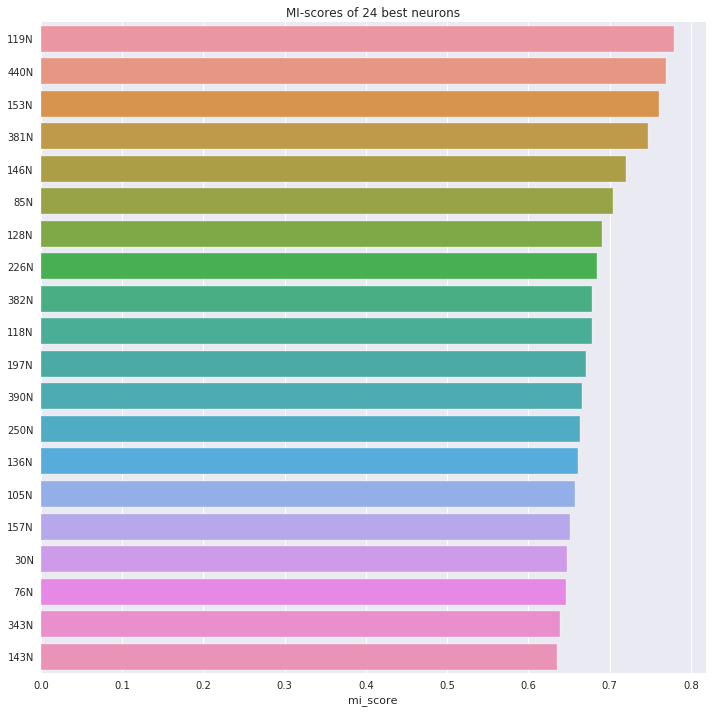

In [19]:
fig, ax = plt.subplots(figsize=(10, 10), ncols=1)

ax = sns.barplot(x=mi_scores_df['mi_score'], y=mi_scores_df.index, ax=ax);
ax.set_title("MI-scores of 24 best neurons");
fig.tight_layout();

# Plotting the path

In [56]:
N_DOTS = 2
N_NEURONS = 2

In [57]:
neurons_to_watch = mi_scores_df.index[:N_NEURONS]

In [58]:
def make_heat_plot(ax, full, neuron):
    s = full.loc[:, ['x', 'y', neuron]].sort_values(neuron)
    s[neuron] = quantile_transform(s[neuron].values.reshape(-1, 1), copy=True)
    ax.scatter(s['x'], s['y'],
                c=s[neuron],
                cmap='viridis',
                linewidth=0,
                s=np.exp(5*s[neuron]),
                alpha=0.1,
                edgecolors='none')

def init_scat_plot(ax, full, colors, sizes):
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    ax.set_title('rodent')
    scat = ax.scatter(full[:N_DOTS]['x'], full[:N_DOTS]['y'], lw=2)
    scat.set_color(colors)
    scat.set_sizes(sizes)
    return scat

def init_cell_plot(ax, full, neuron):
    nl = full[neuron]
    ax.set_xlim(0, 10)
    ax.set_ylim(nl.min(), nl.max())
    ax.set_title(neuron)
    line, = ax.plot(nl[:N_DOTS])
    return line

In [59]:
def update_scat(scat, full, i):
    scat.set_offsets(np.array([full[i:i+N_DOTS]['x'], full[i:i+N_DOTS]['y']]).T)

def update_line(line, full, neuron, i):
    nl = full[neuron]
    start = 0
    if i > 500:
        start = i - 500
    line.set_data(np.linspace(0, 10, i+N_DOTS-start), nl[start:i+N_DOTS])

In [60]:
%matplotlib notebook

<IPython.core.display.Javascript object>


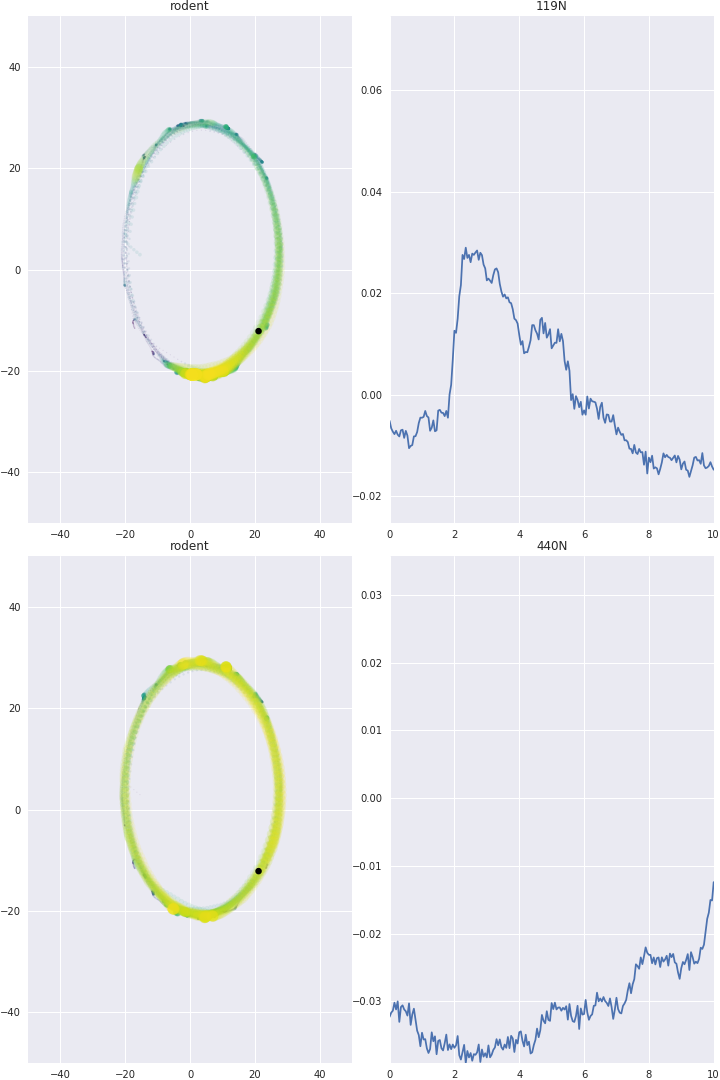

In [61]:
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import numpy as np

from sklearn.preprocessing import quantile_transform

fig, ax =  plt.subplots(figsize=(10, 15), ncols=2, nrows=N_NEURONS)

colors = np.concatenate((np.zeros((N_DOTS, 3)), np.linspace(0, 1, N_DOTS).reshape(1,-1).T), axis=1)
sizes = np.exp(np.linspace(0, 3, N_DOTS))

nsl = []
for i, n in enumerate(neurons_to_watch):
    make_heat_plot(ax[i][0], full, n)
    scat = init_scat_plot(ax[i][0], full, colors, sizes)
    line = init_cell_plot(ax[i][1], full, n)
    nsl.append((n, scat, line))


# animation function 
def animate(i):
    for n, scat, line in nsl:
        update_scat(scat, full, i)
        update_line(line, full, n, i)


# call the animator
anim = animation.FuncAnimation(fig, animate,frames=1000,
                               interval=10, repeat=True, blit=True)

#writer = PillowWriter(fps=25)  
#anim.save("demo_sine.gif", writer=writer) 

plt.tight_layout(pad=0)
plt.show()